### Data Exploration part

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('data/driving_log.csv')

In [6]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [7]:
import numpy as np
import matplotlib.pyplot as plt

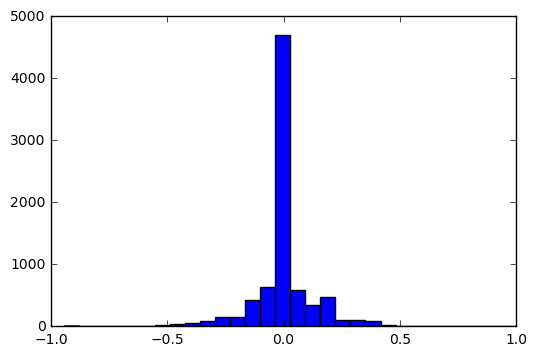

In [8]:
plt.hist(df['steering'], bins=30)
plt.show()

looks like there are too many angle of zeros, try to get rid of this in generator function 

In [59]:
print("angles not 0.0: {} angle is 0.0: {}".format(len(df[df['steering'] != 0.0]),len(df[df['steering'] == 0.0])))

angles not 0.0: 3675 angle is 0.0: 4361


### Utilities 
for data augmentation

In [167]:
from skimage import img_as_ubyte
from skimage import exposure
from skimage.transform import resize
from scipy.misc import imresize

def brightness(image):
    gain = (np.random.randint(3)+3)/10
    return exposure.adjust_gamma(image, gamma=1.0, gain=gain)

def my_resize(image):
    return imresize(image, size=(128,128,3))

def pix_val(im):
    cons = (np.random.randint(6)+7)*10
    for idx,val in enumerate(im):
        for idx2,val2 in enumerate(val):
            for idx3,val3 in enumerate(val2):
                tmp = val3-cons
                if tmp < 0:
                    im[idx,idx2,idx3] = 0
                else:
                    im[idx,idx2,idx3] = tmp
    return im

def random_shadow(image):
    lo_bound = np.random.randint(0,88)
    hi_bound = lo_bound + 40
    new_img = image.copy()
    new_img[:,lo_bound:hi_bound] = pix_val(new_img[:,lo_bound:hi_bound])
    return new_img

def flipping(image):
    return np.fliplr(image)

def process_image(img):
    resized = my_resize(img)
    if np.random.randint(2) == 1:
        processed_img = brightness(resized)
    else:
        processed_img = random_shadow(resized)
    return processed_img

To validate that process_image() work

In [73]:
from PIL import Image

In [74]:
path = "data/"
a=np.asarray(Image.open(path + df['center'][0].strip()))

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [168]:
resized = my_resize(a)

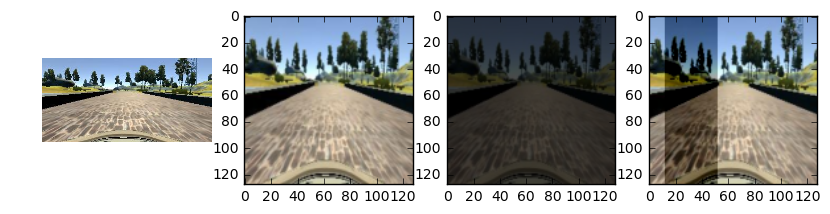

In [170]:
fig, axs = plt.subplots(1,4, figsize=(10, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].imshow(a, cmap='gray')
axs[1].imshow(my_resize(a))
axs[2].imshow(process_image(a))
axs[3].imshow(process_image(a))
plt.show()

In [137]:
process_image(a).shape

(128, 128, 3)

In [82]:
from tqdm import tqdm
import csv

a test pipeline before used in generator

In [83]:
car_images = []
steering_angles = []
with open('data/driving_log.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in tqdm(reader):
        steering_center = float(row[3])
        
        # get rid off too much centered dataset
        if (steering_center == 0.0 and round(np.random.randint(10)) == 0) or steering_center != 0.0:

            # create adjusted steering measurements for the side camera images
            correction = 0.2 # this is a parameter to tune
            steering_left = steering_center + correction
            steering_right = steering_center - correction

            # read in images from center, left and right cameras
            path = "data/" # fill in the path to your training IMG directory
            img_center = np.asarray(Image.open(path + row[0].strip()))
            img_left = np.asarray(Image.open(path + row[1].strip()))
            img_right = np.asarray(Image.open(path + row[2].strip()))
            
            processed_img_center = process_image(img_center)
            processed_img_left = process_image(img_left)
            processed_img_right = process_image(img_right)
            
            # add images and angles to data set
            car_images.extend([img_center, img_left, img_right])
            steering_angles.extend([steering_center, steering_left, steering_right])
            
            car_images.extend([processed_img_center, processed_img_left, processed_img_right])
            steering_angles.extend([steering_center, steering_left, steering_right])
            
            # DO THE FLIP
            img_center_flip = flipping(img_center)
            img_left_flip = flipping(img_left)
            img_right_flip = flipping(img_right)
            
            processed_img_center_flip = flipping(processed_img_center)
            processed_img_left_flip = flipping(processed_img_left)
            processed_img_right_flip = flipping(processed_img_right)
            
            # FLIP DA ANGLE
            steering_center_flip = -steering_center
            steering_left_flip = -steering_left
            steering_right_flip = -steering_right
            
            # Append to the list
            car_images.extend([img_center_flip, img_left_flip, img_right_flip])
            steering_angles.extend([steering_center_flip, steering_left_flip, steering_right_flip])
            
            car_images.extend([processed_img_center_flip, processed_img_left_flip, processed_img_right_flip])
            steering_angles.extend([steering_center_flip, steering_left_flip, steering_right_flip])

8036it [03:06, 43.16it/s]


Expected result of the pipeline, more data was generated

In [239]:
len(steering_angles)

49404

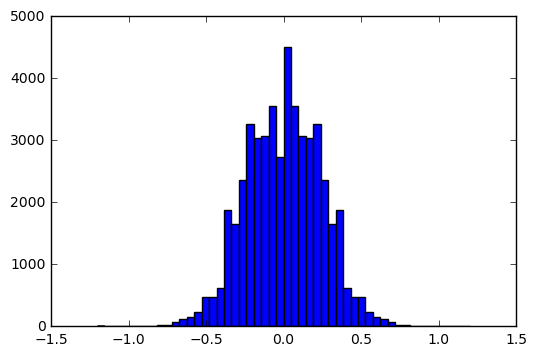

In [84]:
plt.hist(steering_angles, bins=50)
plt.show()

### Preprocessing
1. Flipping
1. Brightness
1. Resize
1. Random vertical shadow

### Validation
1. Use the image from center camera only

In [204]:
from keras.models import Sequential, Model
from keras.layers import Lambda, Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D

In [237]:
import os
import csv
from sklearn.utils import shuffle

samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import numpy as np
import sklearn
from sklearn.utils import shuffle
from tqdm import tqdm

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []
            steering_angles = []
            for batch_sample in batch_samples:
                steering_center = float(batch_sample[3])
                
                if (steering_center == 0.0 and round(np.random.randint(10)) == 0) or steering_center != 0.0:

                    # create adjusted steering measurements for the side camera images
                    correction = 0.2 # this is a parameter to tune
                    steering_left = steering_center + correction
                    steering_right = steering_center - correction

                    # read in images from center, left and right cameras
                    path = "data/" # fill in the path to your training IMG directory
                    img_center = my_resize(np.asarray(Image.open(path + batch_sample[0].strip())))
                    img_left = my_resize(np.asarray(Image.open(path + batch_sample[1].strip())))
                    img_right = my_resize(np.asarray(Image.open(path + batch_sample[2].strip())))

                    processed_img_center = process_image(img_center)
                    processed_img_left = process_image(img_left)
                    processed_img_right = process_image(img_right)

                    # add images and angles to data set
                    car_images.extend([img_center, img_left, img_right])
                    steering_angles.extend([steering_center, steering_left, steering_right])

                    car_images.extend([processed_img_center, processed_img_left, processed_img_right])
                    steering_angles.extend([steering_center, steering_left, steering_right])

#                     DO THE FLIP
                    img_center_flip = flipping(img_center)
                    img_left_flip = flipping(img_left)
                    img_right_flip = flipping(img_right)

                    processed_img_center_flip = flipping(processed_img_center)
                    processed_img_left_flip = flipping(processed_img_left)
                    processed_img_right_flip = flipping(processed_img_right)

#                     # FLIP DA ANGLE
                    steering_center_flip = -steering_center
                    steering_left_flip = -steering_left
                    steering_right_flip = -steering_right

#                     Append to the list
                    car_images.extend([img_center_flip, img_left_flip, img_right_flip])
                    steering_angles.extend([steering_center_flip, steering_left_flip, steering_right_flip])

                    car_images.extend([processed_img_center_flip, processed_img_left_flip, processed_img_right_flip])
                    steering_angles.extend([steering_center_flip, steering_left_flip, steering_right_flip])
                    
            # trim image to only see section with road
            X_train = np.array(car_images)
            y_train = np.array(steering_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

            
# just like the train generator() but get only the center image and steering center
def valid_generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                steering_center = float(batch_sample[3])
                
                # read in images from center, left and right cameras
                path = "data/" # fill in the path to your training IMG directory
                img_center = np.asarray(Image.open(path + batch_sample[0].strip()))
                resized = my_resize(img_center)
                # add images and angles to data set
                images.extend([resized])
                angles.extend([steering_center])
                    
            # trim image to only see section with road
            X_valid = np.array(images)
            y_valid = np.array(angles)
            yield sklearn.utils.shuffle(X_valid, y_valid)

            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = valid_generator(validation_samples, batch_size=32)

model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(128,128,3,), name='input_normalization'))

model.add(Cropping2D(cropping=((50,20), (0,0)), name='top:50px/bottom:20px'))

model.add(Convolution2D(24, 5, 5, subsample = (2,2), name='24Aconv5x5/stride2'))
model.add(Activation('elu', name='ELU_1'))

model.add(Convolution2D(36, 5, 5, subsample = (2,2), name='36Aconv5x5/stride2'))
model.add(Activation('elu', name='ELU_2'))

model.add(Convolution2D(48, 5, 5, subsample = (2,2), name='48Aconv5x5/stride2'))
model.add(Activation('elu', name='ELU_3'))

model.add(Convolution2D(64, 3, 3, name='64Aconv5x5/stride1'))
model.add(Activation('elu', name='ELU_4'))

model.add(Flatten(name='Flat'))

model.add(Dense(1000,name='1000-FC'))
model.add(Activation('elu', name='ELU_5'))

model.add(Dropout(0.5, name='DROPOUT_1_p0.5'))

model.add(Dense(100,name='100-FC'))
model.add(Activation('elu', name='ELU_6'))

model.add(Dropout(0.5, name='DROPOUT_2_p0.5'))

model.add(Dense(50, name='50-FC'))
model.add(Activation('elu', name='ELU_7'))

model.add(Dropout(0.5, name='DROPOUT_3_p0.5'))

model.add(Dense(1, name='1-FC'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_normalization (Lambda)     (None, 128, 128, 3)   0           lambda_input_52[0][0]            
____________________________________________________________________________________________________
top:50px/bottom:20px (Cropping2D (None, 58, 128, 3)    0           input_normalization[0][0]        
____________________________________________________________________________________________________
24Aconv5x5/stride2 (Convolution2 (None, 27, 62, 24)    1824        top:50px/bottom:20px[0][0]       
____________________________________________________________________________________________________
ELU_1 (Activation)               (None, 27, 62, 24)    0           24Aconv5x5/stride2[0][0]         
___________________________________________________________________________________________

Epoch 1/60
6516/6428 [==============================] - 35s - loss: 0.0549 - val_loss: 0.0223
Epoch 2/60
6636/6428 [==============================] - 28s - loss: 0.0477 - val_loss: 0.0282
Epoch 3/60
6540/6428 [==============================] - 26s - loss: 0.0458 - val_loss: 0.0197
Epoch 4/60
6516/6428 [==============================] - 25s - loss: 0.0445 - val_loss: 0.0162
Epoch 5/60
6456/6428 [==============================] - 25s - loss: 0.0361 - val_loss: 0.0280
Epoch 6/60
6576/6428 [==============================] - 25s - loss: 0.0360 - val_loss: 0.0192
Epoch 7/60
6564/6428 [==============================] - 27s - loss: 0.0386 - val_loss: 0.0275
Epoch 8/60
6660/6428 [===============================] - 26s - loss: 0.0404 - val_loss: 0.0236
Epoch 9/60
6504/6428 [==============================] - 26s - loss: 0.0405 - val_loss: 0.0200
Epoch 10/60
6468/6428 [==============================] - 25s - loss: 0.0370 - val_loss: 0.0200
Epoch 11/60
6540/6428 [==============================] - 2

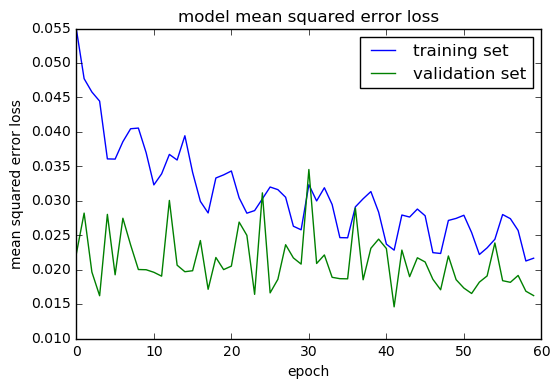

In [209]:
import matplotlib.pyplot as plt

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=60, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [211]:
model.save('model_new60.h5')

In [238]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')